# Fine-Tuning 

##  Project -> Given a description of a product, predict its Price 

A model that can estimate how much something costs, from its description.

## What is Fine-tuning:-

* Finetuning is one of the method for **Transfer learning**

**Transfer Learning** is a machine learning technique where a model trained on one task is reused (wholly or partially) for another related task. 

Instead of training a model from scratch, transfer learning leverages knowledge from a pre-trained model, adapting it to a new problem with minimal additional training.

***Key Aspects:***

    - Pre-trained Model: A model trained on a large dataset (e.g., ImageNet for images, GPT for text).
    - Knowledge Transfer: The learned features from the pre-trained model are reused for a different but related task.
    - Fine-tuning: The final layers of the model are adjusted (or retrained) to specialize in the new task.
***Example:***

    - Using a pre-trained GPT model for a specific medical chatbot by fine-tuning it with medical-specific text data.
    - Applying a pre-trained image recognition model (e.g., ResNet) to classify medical images with additional training.
    - Transfer learning speeds up training and improves accuracy, especially when labeled data is limited.

Fine-tuning is the process of taking a pre-trained machine learning model (especially in deep learning or LLMs) and further training it on a smaller, domain-specific dataset to improve its performance on a particular task.

It helps the model adapt to specialized needs without training from scratch, saving time and resources. Fine-tuning is commonly used in NLP, computer vision, and speech recognition to make models more relevant to specific applications.


##### Objective of the project: A model that can estimate how much something costs, from its description.

### Data Curation -- Loading and Visualizing

Scrubbing and curating our dataset by focusing on a subset of the data: ***Home Appliances.***

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [21]:
# imports
import os
import random
import pickle
import numpy as np
from items import Item
from dotenv import load_dotenv
from loaders import ItemLoader
import matplotlib.pyplot as plt
from huggingface_hub import login
from collections import Counter, defaultdict
from datasets import load_dataset, Dataset, DatasetDict

In [2]:
# environment
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# One more import - the Item class
# If you get an error that you need to agree to Meta's terms when you run this, then follow the link it provides you and follow their instructions
# You should get approved by Meta within minutes
# Any problems - message me or email me!
# With thanks to student Dr John S. for pointing out that this import needs to come after signing in to HF
from items import Item

c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Load the dataset

In [3]:
from datasets import get_dataset_config_names
dataset_name = "McAuley-Lab/Amazon-Reviews-2023"
available_datasets = get_dataset_config_names(dataset_name, trust_remote_code=True)
print("Available datasets:", available_datasets)

Available datasets: ['raw_meta_All_Beauty', 'raw_meta_Toys_and_Games', 'raw_meta_Cell_Phones_and_Accessories', 'raw_meta_Industrial_and_Scientific', 'raw_meta_Gift_Cards', 'raw_meta_Musical_Instruments', 'raw_meta_Electronics', 'raw_meta_Handmade_Products', 'raw_meta_Arts_Crafts_and_Sewing', 'raw_meta_Baby_Products', 'raw_meta_Health_and_Household', 'raw_meta_Office_Products', 'raw_meta_Digital_Music', 'raw_meta_Grocery_and_Gourmet_Food', 'raw_meta_Sports_and_Outdoors', 'raw_meta_Home_and_Kitchen', 'raw_meta_Subscription_Boxes', 'raw_meta_Tools_and_Home_Improvement', 'raw_meta_Pet_Supplies', 'raw_meta_Video_Games', 'raw_meta_Kindle_Store', 'raw_meta_Clothing_Shoes_and_Jewelry', 'raw_meta_Patio_Lawn_and_Garden', 'raw_meta_Unknown', 'raw_meta_Books', 'raw_meta_Automotive', 'raw_meta_CDs_and_Vinyl', 'raw_meta_Beauty_and_Personal_Care', 'raw_meta_Amazon_Fashion', 'raw_meta_Magazine_Subscriptions', 'raw_meta_Software', 'raw_meta_Health_and_Personal_Care', 'raw_meta_Appliances', 'raw_meta_Mo

In [4]:
# Load in our dataset
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


## Visualize the data

In [5]:
# Investigate a particular datapoint
datapoint = dataset[2]

# Investigate
print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

Clothes Dryer Drum Slide, General Electric, Hotpoint, WE1M333, WE1M504
['Brand new dryer drum slide, replaces General Electric, Hotpoint, RCA, WE1M333, WE1M504.']
[]
{"Manufacturer": "RPI", "Part Number": "WE1M333,", "Item Weight": "0.352 ounces", "Package Dimensions": "5.5 x 4.7 x 0.4 inches", "Item model number": "WE1M333,", "Is Discontinued By Manufacturer": "No", "Item Package Quantity": "1", "Batteries Included?": "No", "Batteries Required?": "No", "Best Sellers Rank": {"Tools & Home Improvement": 1315213, "Parts & Accessories": 181194}, "Date First Available": "February 25, 2014"}
None


In [6]:
# How many have prices?
prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [7]:
# For those with prices, gather the price and the length
prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

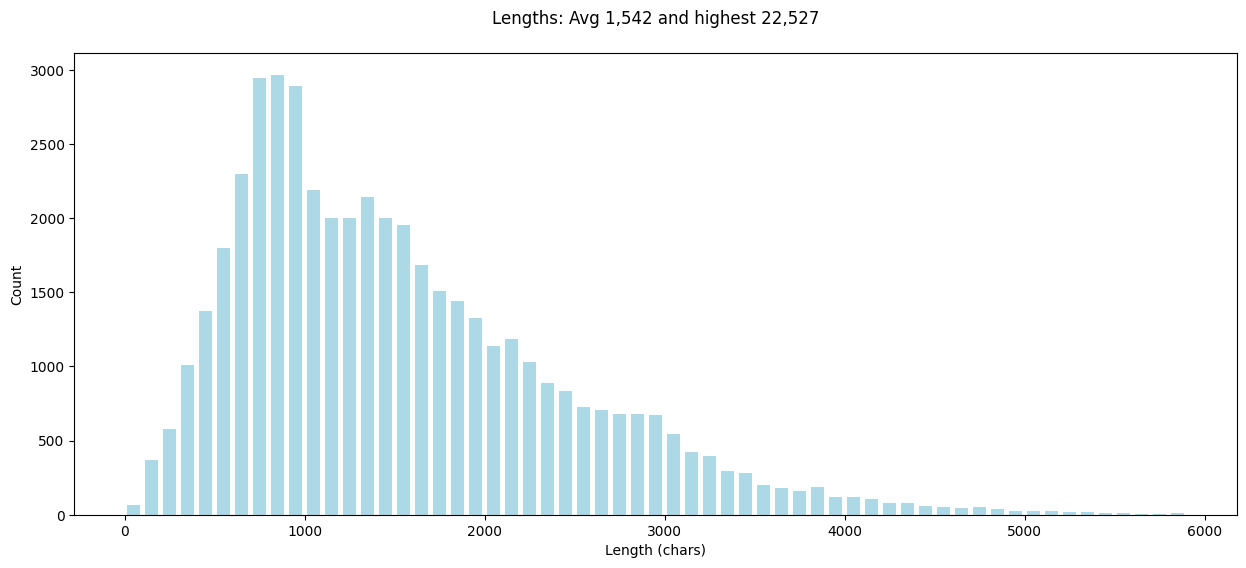

In [8]:
%matplotlib inline
# Plot the distribution of lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

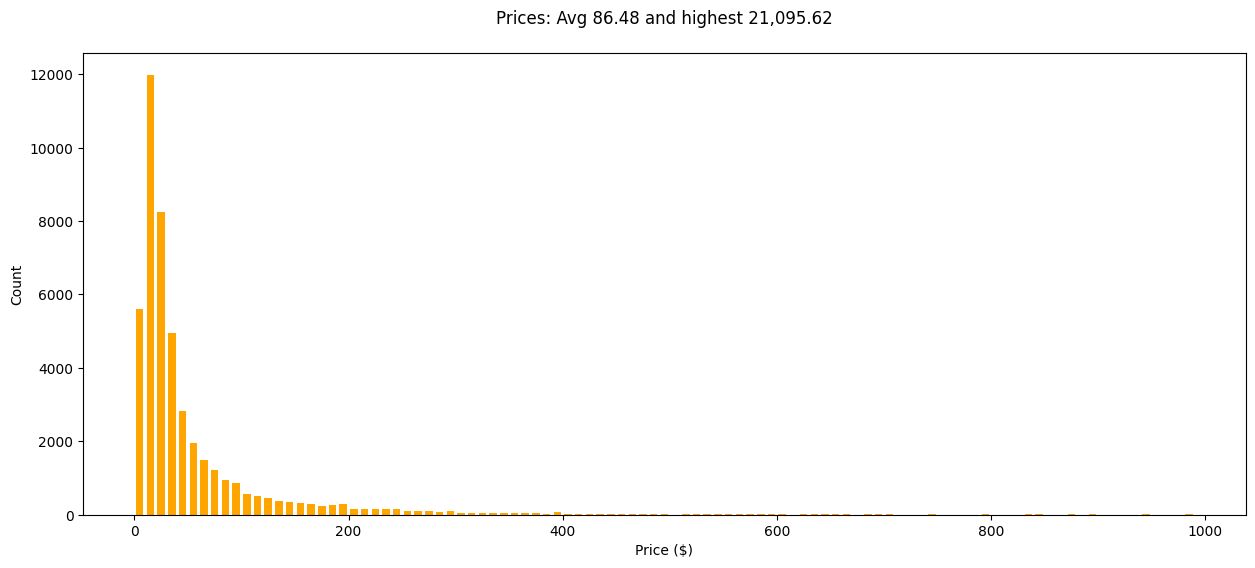

In [9]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [10]:
# So what is this item??
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


## Data Curation

* We select items that cost between 1 and 999 USD

* We will be create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer

* And will create a prompt to be used during Training.

* Items will be rejected if they don't have sufficient characters.

### But why 180 tokens??

Why are we truncating to 180 tokens? How did we determine that number? 

The answer: this is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. You'll see this in action in Week 7.

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.

### But I see in items.py it constrains inputs to 160 tokens?

Another great question ! The description of the products is limited to 160 tokens because we add some more text before and after the description to turn it into a prompt. That brings it to around 180 tokens in total.

In [14]:
# Create an Item object for each with a price
from items import Item
items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 29,191 items


In [15]:
# Look at the first item
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [16]:
# Investigate the prompt that will be used during training - the model learns to complete this
print(items[100].prompt)

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $118.00


In [17]:
# Investigate the prompt that will be used during testing - the model has to complete this
print(items[100].test_prompt())

How much does this cost to the nearest dollar?

Samsung Assembly Ice Maker-Mech
This is an O.E.M. Authorized part, fits with various Samsung brand models, oem part # this product in manufactured in south Korea. This is an O.E.M. Authorized part Fits with various Samsung brand models Oem part # This is a Samsung replacement part Part Number This is an O.E.M. part Manufacturer J&J International Inc., Part Weight 1 pounds, Dimensions 18 x 12 x 6 inches, model number Is Discontinued No, Color White, Material Acrylonitrile Butadiene Styrene, Quantity 1, Certification Certified frustration-free, Included Components Refrigerator-replacement-parts, Rank Tools & Home Improvement Parts & Accessories 31211, Available April 21, 2011

Price is $


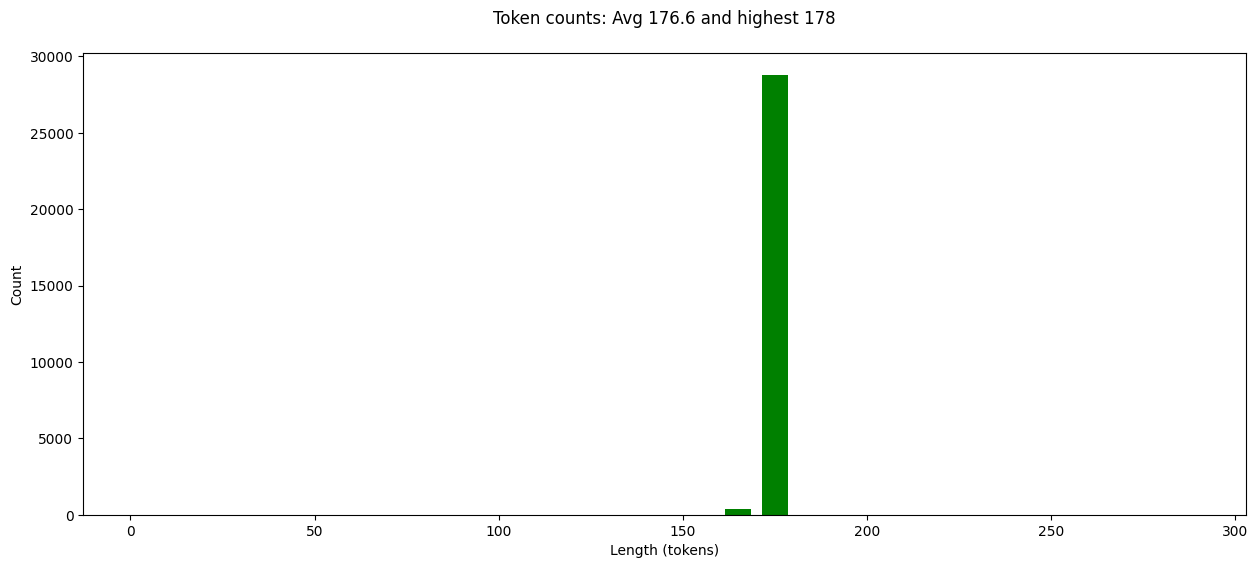

In [18]:
# Plot the distribution of token counts
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

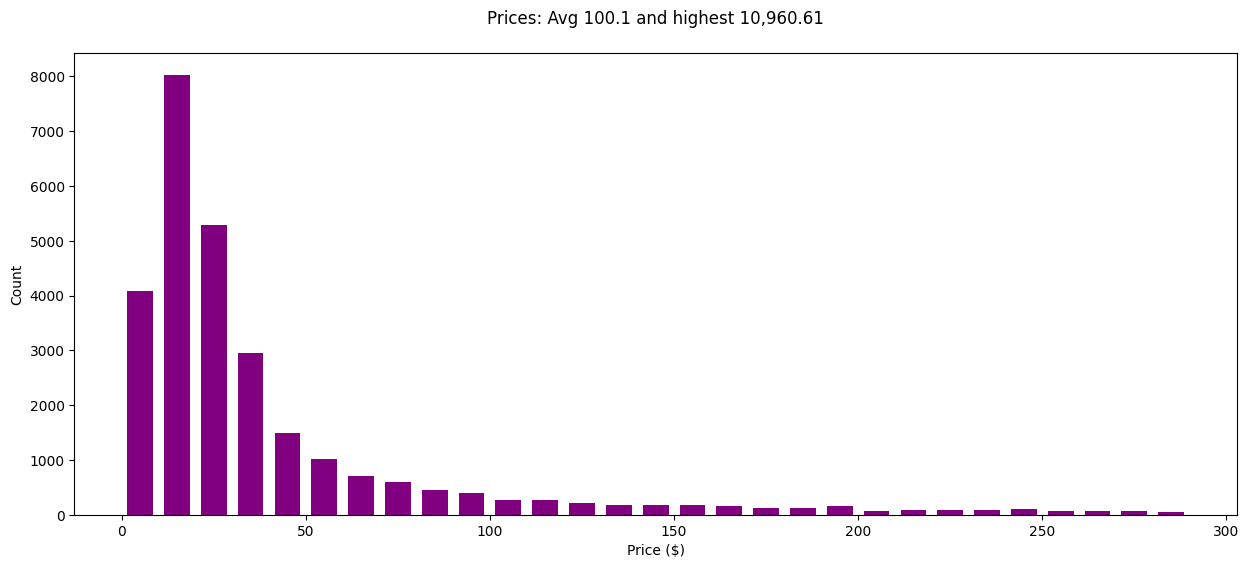

In [19]:
# Plot the distribution of prices
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Todos for you:

- Review the Item class and check you're comfortable with it
- Examine some Item objects, look at the training prompt with `item.prompt` and test prompt with `item.test_prompt()`
- Make some more histograms to better understand the data



##### Data Curation -- Part 2

***NB: Objective of the project: A model that can estimate how much something costs, from its description.***

##### Important Note - read me first please

We are about to craft a massive dataset of 400,000 items covering multiple types of product. In Week 7 we will be using this data to train our own model. It's a pretty big dataset, and depending on the GPU you select, training could take 20+ hours. It will be really good fun, but it could cost a few dollars in compute units.

As an alternative, if you want to keep things quick & low cost, you can work with a smaller dataset focused only on Home Appliances. You'll be able to cover the same learning points; the results will be good -- not quite as good as the full dataset, but still pretty amazing! If you'd prefer to do this, I've set up an alternative jupyter notebook in this folder called `lite.ipynb` that you should use in place of this one.



In [22]:
%matplotlib inline

# Load in the same dataset as last time
items = ItemLoader("Appliances").load()

Loading dataset Appliances


100%|██████████| 95/95 [00:24<00:00,  3.81it/s]


Completed Appliances with 28,625 datapoints in 0.5 mins


In [21]:
# Look for a familiar item..
print(items[1].prompt)

How much does this cost to the nearest dollar?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


### Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [22]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [23]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# Now, time for a coffee break!!
# By the way, I put the biggest datasets first.. it gets faster.

Loading dataset Automotive


100%|██████████| 2004/2004 [08:38<00:00,  3.87it/s]


Completed Automotive with 911,688 datapoints in 8.8 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [05:28<00:00,  4.91it/s]


Completed Electronics with 443,473 datapoints in 5.6 mins
Loading dataset Office_Products


100%|██████████| 711/711 [02:11<00:00,  5.42it/s]


Completed Office_Products with 240,394 datapoints in 2.3 mins
Loading dataset Tools_and_Home_Improvement


100%|██████████| 1474/1474 [05:33<00:00,  4.42it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 5.7 mins
Loading dataset Cell_Phones_and_Accessories


100%|██████████| 1289/1289 [03:22<00:00,  6.36it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 3.5 mins
Loading dataset Toys_and_Games


100%|██████████| 891/891 [03:09<00:00,  4.70it/s]


Completed Toys_and_Games with 340,479 datapoints in 3.3 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:24<00:00,  3.81it/s]


Completed Appliances with 28,625 datapoints in 0.5 mins
Loading dataset Musical_Instruments


100%|██████████| 214/214 [00:41<00:00,  5.10it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.8 mins


In [24]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,811,408 items


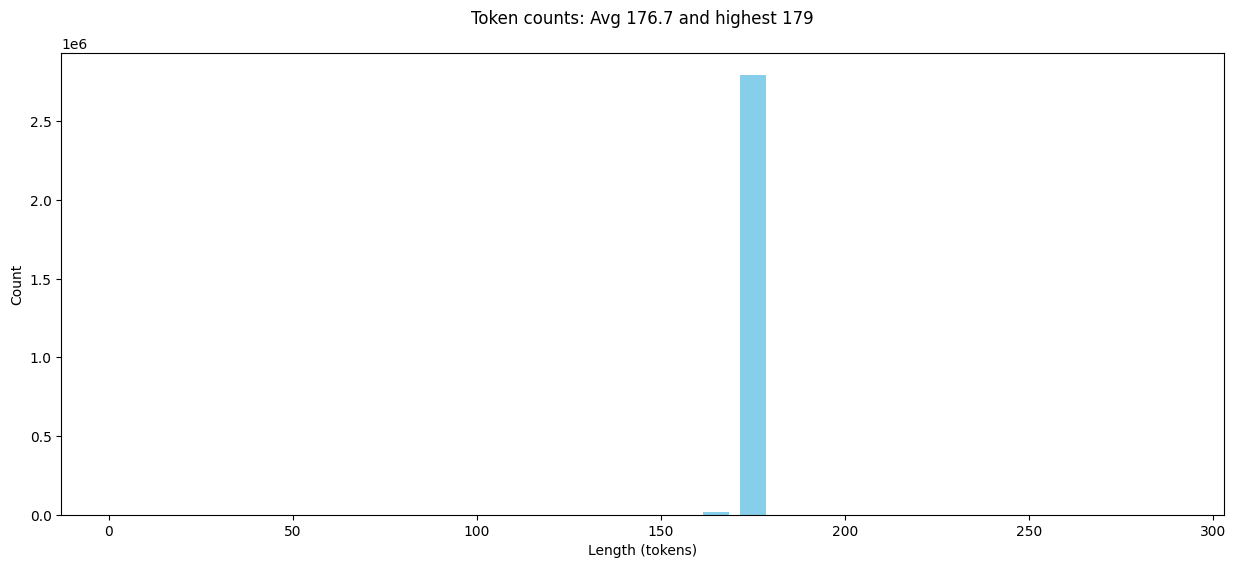

In [25]:
# Plot the distribution of token counts again
tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

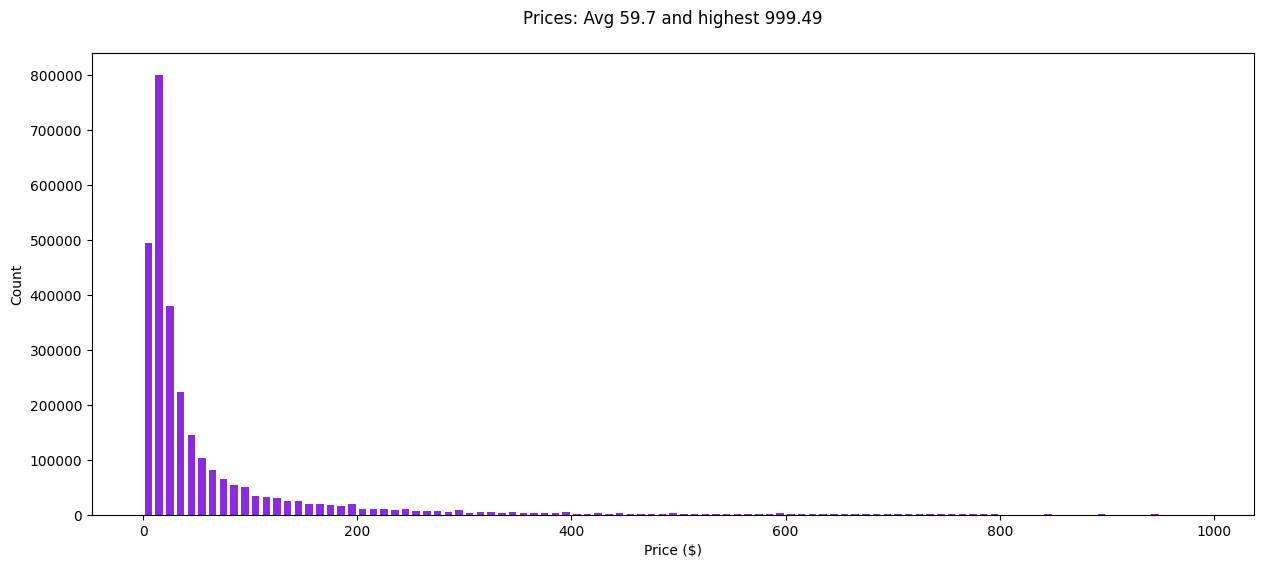

In [26]:
# Plot the distribution of prices
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

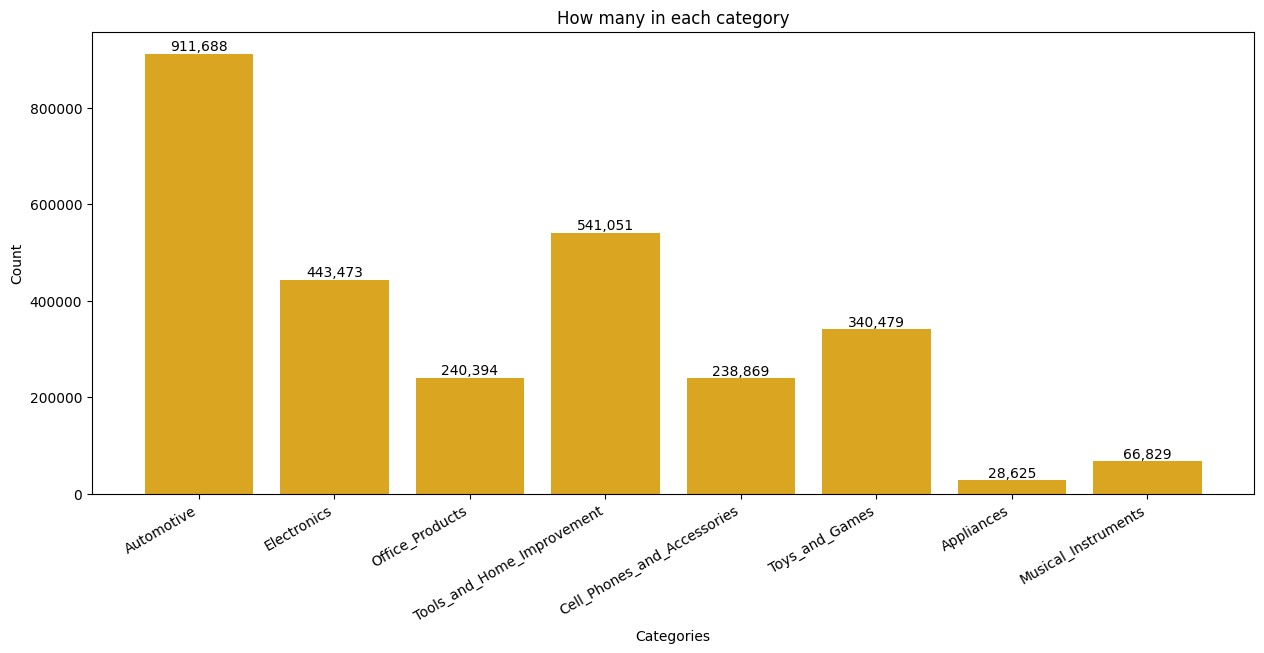

In [27]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

###  Objective

Craft a dataset which is more balanced in terms of prices. Less heavily scewed to cheap items, with an average that's higher than $60. Try to balance out the categories - fewer Automotive items.

In [28]:
# Create a dict with a key of each price from $1 to $999
# And in the value, put a list of items with that price (to nearest round number)
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [29]:
# Create a dataset called "sample" which tries to more evenly take from the range of prices
# And gives more weight to items from categories other than Automotive
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot)<=1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"There are {len(sample):,} items in the sample")

There are 408,635 items in the sample


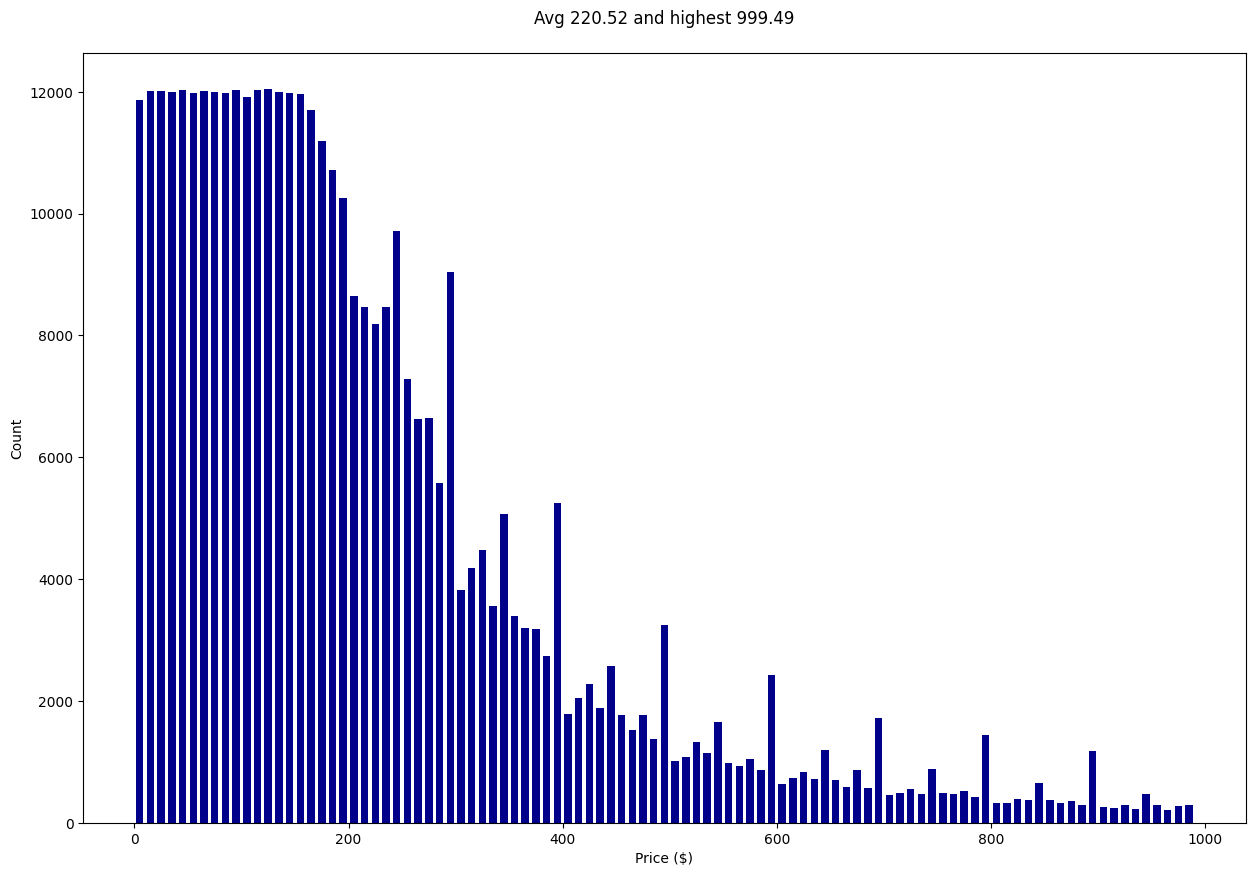

In [30]:
# Plot the distribution of prices in sample

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

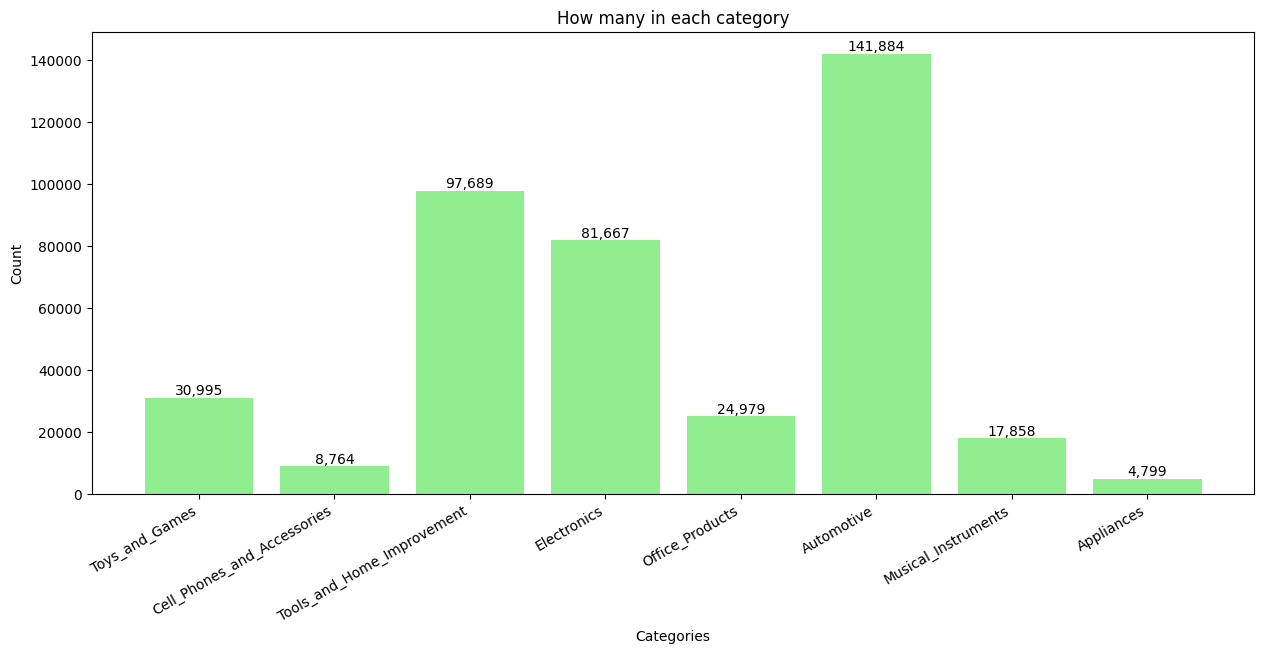

In [31]:
# OK, we did well in terms of raising the average price and having a smooth-ish population of prices
# Let's see the categories

category_counts = Counter()
for item in sample:
    category_counts[item.category] += 1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

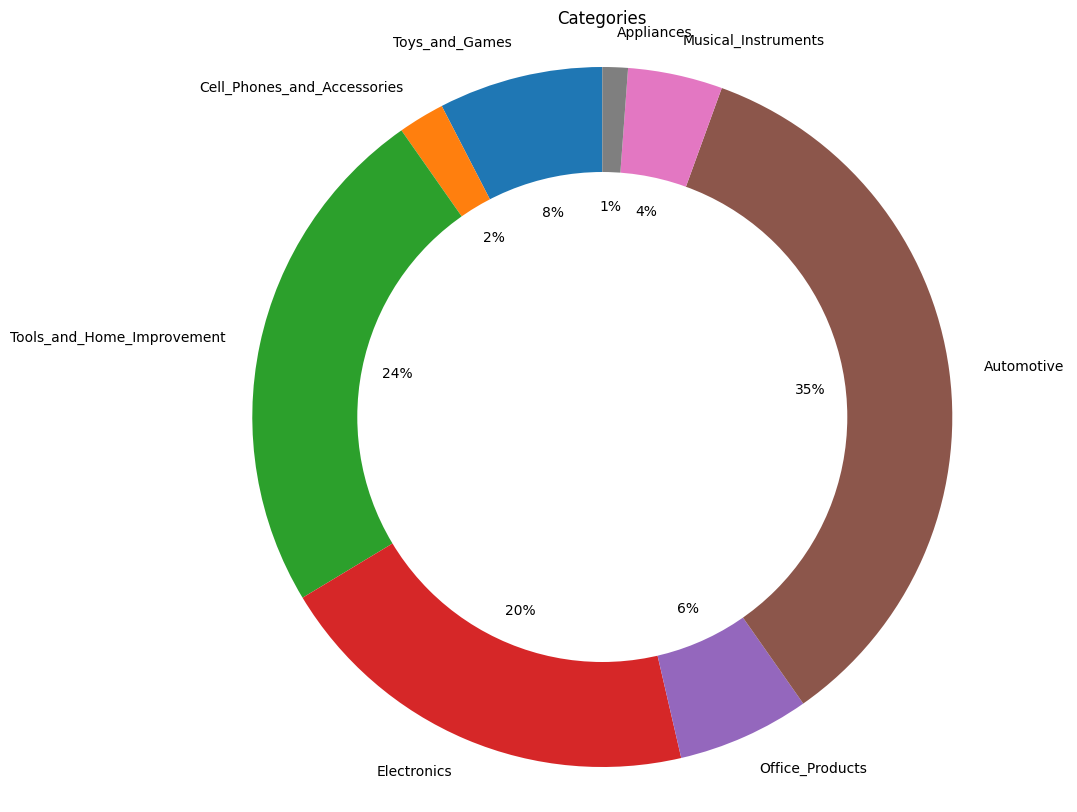

In [32]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

plt.show()

## Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

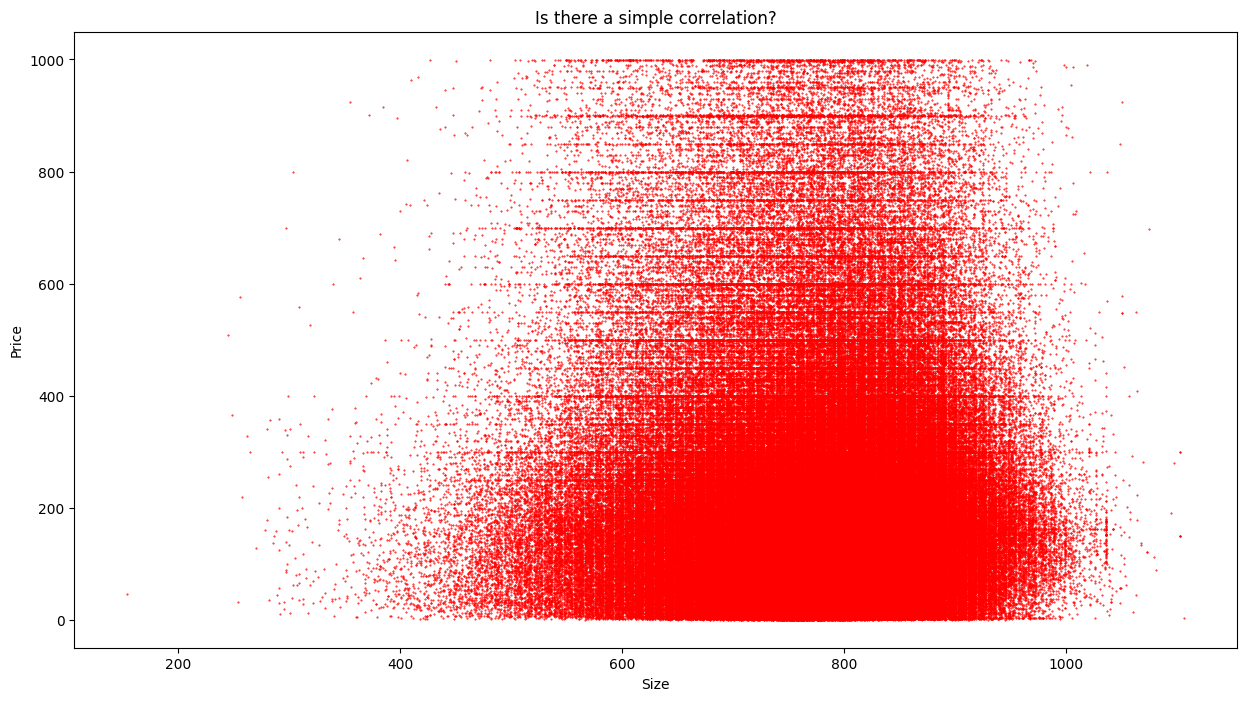

In [33]:
# How does the price vary with the character count of the prompt?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [34]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

# Example 
report(sample[398000])

How much does this cost to the nearest dollar?

MonoRS Coilovers Lowering Kit Made For Scion FRS Fully Adjustable, Set of 4
MonoRS Coilover damper kit by Godspeed Project are intermediate suspension upgrade setup for daily and Sunday club racing. Lowering your car with improved springs over factory and paired with Mono-tubo shocks with valving that allows 32 levels of rebound adjustment to improve handling without sacrifice comfort. Ride height can easily be adjusted by twisting the lower mount bracket. In order to keep weight gain at the minimum, most of attachments and accessories are CNC machined from billet aluminum. Koyo bearings are used when camber plate top mount is applicable depends on car models. To assure that our customers are getting high quality products, MonoRS coilovers are covered by 12 months limited warranty by the manufacturer from

Price is $765.00
[279, 14290, 505, 271, 7117, 374, 400, 22240, 13, 410]
[' the', ' manufacturer', ' from', '\n\n', 'Price', ' is', ' $

## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 400,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.

In [35]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 400,000 items and test set of 2,000 items


In [36]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [37]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


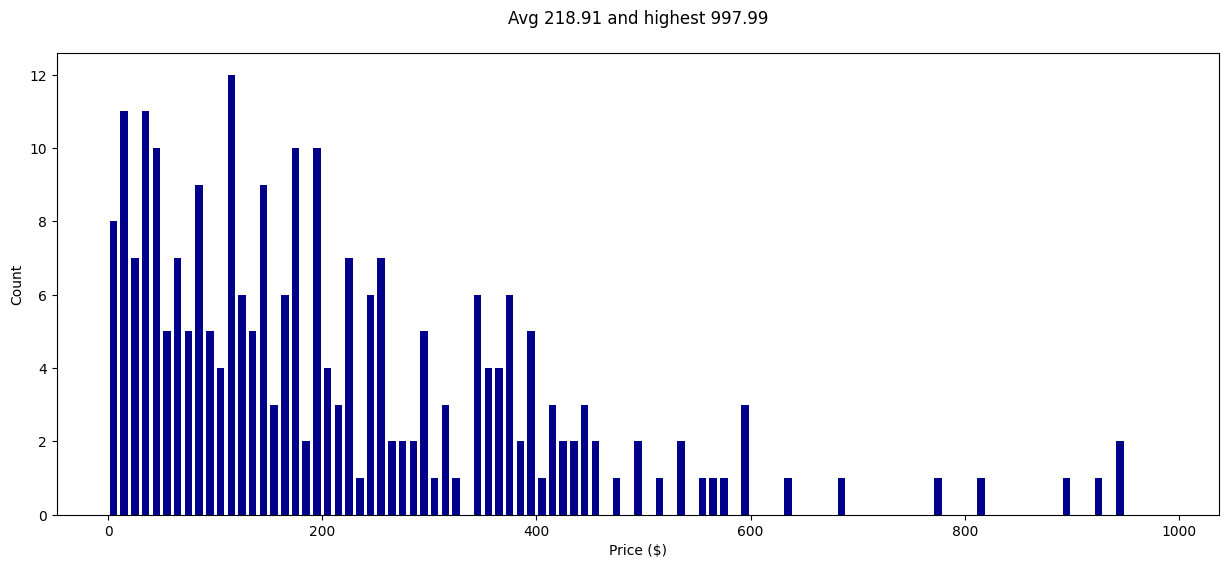

In [38]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

### Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [39]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [40]:
# Create a Dataset from the lists
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [41]:
# Uncomment these lines if you're ready to push to the hub, and replace my name with your HF username
dataset.push_to_hub("tazeb6531/pricer-data", private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]
c:\Users\tazeb\OneDrive\AtomicHabit\LLM Engineering\venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tazeb\.cache\huggingface\hub\datasets--tazeb6531--pricer-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files hav

CommitInfo(commit_url='https://huggingface.co/datasets/tazeb6531/pricer-data/commit/e8fb6419d31f1194acbc6ee7e9820a1bd04f2502', commit_message='Upload dataset', commit_description='', oid='e8fb6419d31f1194acbc6ee7e9820a1bd04f2502', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/tazeb6531/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='tazeb6531/pricer-data'), pr_revision=None, pr_num=None)

In [42]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

A model that can estimate how much something costs, from its description.

## Baseline Models

Today we work on the simplest models to act as a starting point that we will beat.

In [33]:
# imports
import os
import math
import json
import random
import pickle
import numpy as np
from items import Item
from collections import Counter
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from huggingface_hub import login

In [34]:
# More imports for our traditional machine learning
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## NLP imports

In the next cell, we have more imports for our NLP related machine learning.  
If the gensim import gives you an error like "Cannot import name 'triu' from 'scipy.linalg' then please run in another cell:  
`!pip install "scipy<1.13"`  
As described on StackOverflow [here](https://stackoverflow.com/questions/78279136/importerror-cannot-import-name-triu-from-scipy-linalg-when-importing-gens).  
Many thanks to students Arnaldo G and Ard V for sorting this.

In [35]:
# NLP related imports
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [36]:
# Finally, more imports for more advanced machine learning
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [37]:
# Constants - used for printing to stdout in color
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [38]:
# environment
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [39]:
# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [40]:
%matplotlib inline

# Loading the pkl files

Let's avoid curating all our data again! Load in the pickle files

If you didn't already create these in Day 2, you can also download them from my google drive (you'll also find the slides here):  
https://drive.google.com/drive/folders/1JwNorpRHdnf_pU0GE5yYtfKlyrKC3CoV?usp=sharing

But note that the files are quite large - you might need to get a coffee!

In [23]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [24]:
# Remind ourselves the training prompt
print(train[0].prompt)

How much does this cost to the nearest dollar?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [25]:
# Remind a test prompt
print(train[0].price)

226.95


In [26]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


## Unveiling a mighty script that we will use a lot!

A rather pleasing Test Harness that will evaluate any model against 250 items from the Test set

And show us the results in a visually satisfying way.

You write a function of this form:

```
def my_prediction_function(item):
    # my code here
    return my_estimate
```

And then you call:

`Tester.test(my_prediction_function)`

To evaluate your model.

In [30]:
class Tester:
    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"
    
    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function):
        cls(function).run()

# Now for something basic

What's the very simplest model you could imagine?

Let's start with a random number generator!

In [31]:
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $374.41 Error: $280.59 SLE: 0.31 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $115.00 Truth: $225.11 Error: $110.11 SLE: 0.45 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $26.00 Truth: $61.68 Error: $35.68 SLE: 0.71 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $760.00 Truth: $599.99 Error: $160.01 SLE: 0.06 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $282.00 Truth: $16.99 Error: $265.01 SLE: 7.59 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $251.00 Truth: $31.99 Error: $219.01 SLE: 4.13 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $229.00 Truth: $101.79 Error: $127.21 SLE: 0.65 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $143.00 Truth: $289.00 Error: $146.00 SLE: 0.49 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $755.00 Truth: $635.86 Error: $119.14 SLE: 0.03 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $105.00 Truth: $65.99 Error: $39.01 S

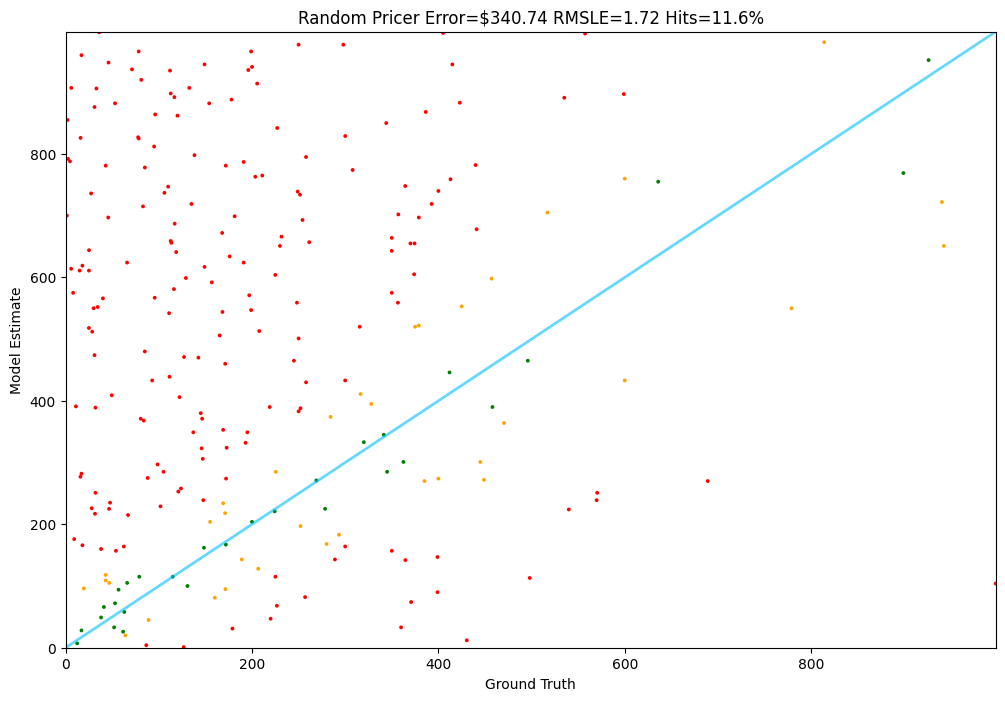

In [41]:
# Set the random seed

random.seed(42)

# Run our TestRunner
Tester.test(random_pricer)

In [42]:
# That was fun!
# We can do better - here's another rather trivial model

training_prices = [item.price for item in train]
training_average = sum(training_prices) / len(training_prices)

def constant_pricer(item):
    return training_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

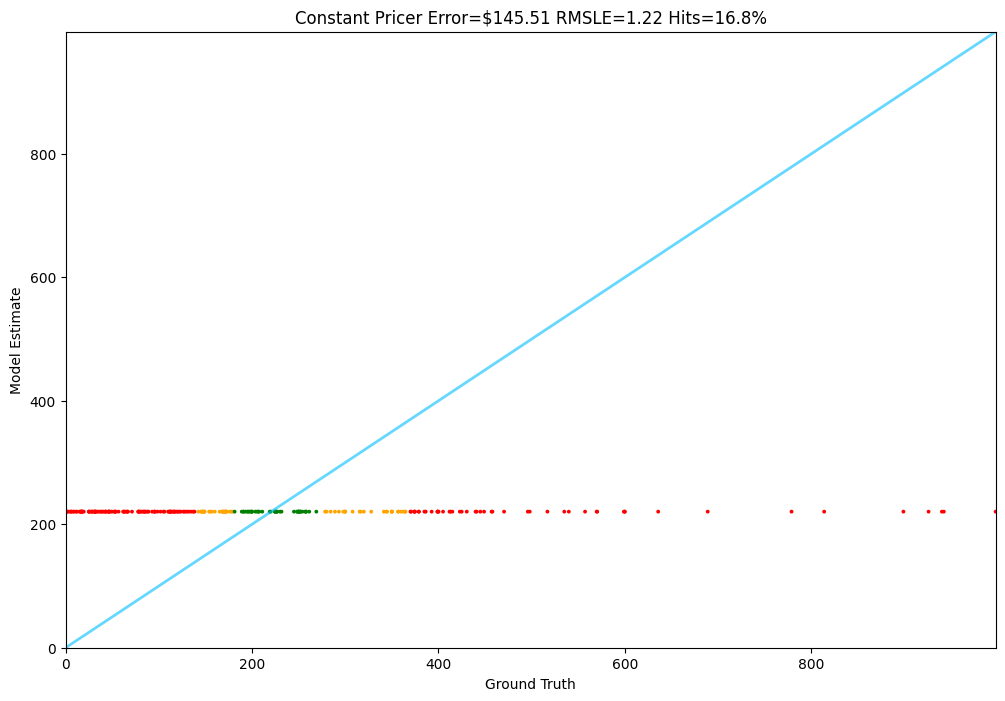

In [43]:
# Run our constant predictor
Tester.test(constant_pricer)

In [44]:
train[0].details

'{"Brand": "Delphi", "Fit Type": "Vehicle Specific Fit", "Item Dimensions LxWxH": "19.7 x 7.7 x 5.1 inches", "Item Weight": "2.2 Pounds", "Auto Part Position": "Unknown", "Operation Mode": "Mechanical", "Manufacturer": "Delphi", "Model": "FUEL PUMP", "Product Dimensions": "19.7 x 7.7 x 5.1 inches", "Country of Origin": "USA", "Item model number": "FG0166", "Is Discontinued By Manufacturer": "No", "Exterior": "Painted", "Manufacturer Part Number": "FG0166", "OEM Part Number": "25326856, 89060639, A30416, E4061R, MU242", "Best Sellers Rank": {"Automotive": 913571, "Automotive Replacement Electric Fuel Pumps": 6568}, "Domestic Shipping": "Item can be shipped within U.S.", "International Shipping": "This item is not eligible for international shipping.  Learn More", "Date First Available": "August 9, 2006"}'

In [45]:
# Create a new "features" field on items, and populate it with json parsed from the details dict

for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)

# Look at one

In [46]:
train[0].features.keys()

dict_keys(['Brand', 'Fit Type', 'Item Dimensions LxWxH', 'Item Weight', 'Auto Part Position', 'Operation Mode', 'Manufacturer', 'Model', 'Product Dimensions', 'Country of Origin', 'Item model number', 'Is Discontinued By Manufacturer', 'Exterior', 'Manufacturer Part Number', 'OEM Part Number', 'Best Sellers Rank', 'Domestic Shipping', 'International Shipping', 'Date First Available'])

In [47]:
# Look at 20 most common features in training set

feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Date First Available', 360062),
 ('Item Weight', 350444),
 ('Manufacturer', 349357),
 ('Brand', 340323),
 ('Best Sellers Rank', 330473),
 ('Item model number', 277573),
 ('Product Dimensions', 262400),
 ('Color', 183794),
 ('Is Discontinued By Manufacturer', 169828),
 ('Manufacturer Part Number', 145092),
 ('Material', 137447),
 ('Country of Origin', 121451),
 ('Style', 77639),
 ('Special Feature', 74709),
 ('Part Number', 74529),
 ('Batteries Required?', 73595),
 ('Package Dimensions', 72900),
 ('Item Dimensions LxWxH', 71385),
 ('Included Components', 67509),
 ('Model', 65144),
 ('Size', 58233),
 ('Item Package Quantity', 58149),
 ('Batteries Included?', 56779),
 ('OEM Part Number', 56062),
 ('Special Features', 53740),
 ('Exterior', 50566),
 ('Power Source', 50256),
 ('Vehicle Service Type', 49420),
 ('Finish Type', 46262),
 ('Voltage', 46036),
 ('Mounting Type', 38043),
 ('Model Name', 37524),
 ('Shape', 34816),
 ('Finish', 31901),
 ('Number of Items', 31871),
 ('Connectivity Te

In [48]:
# Now some janky code to pluck out the Item Weight
# Don't worry too much about this: spoiler alert, it's not going to be much use in training!

def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [49]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [50]:
average_weight = sum(weights)/len(weights)
average_weight

13.57055237029551

In [67]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or average_weight

In [68]:
def get_rank(item):
    rank_dict = item.features.get("Best Sellers Rank")
    if rank_dict:
        ranks = rank_dict.values()
        return sum(ranks)/len(ranks)
    return None

In [69]:
ranks = [get_rank(t) for t in train]
ranks = [r for r in ranks if r]
average_rank = sum(ranks)/len(ranks)
average_rank

380638.258828069

In [70]:
def get_rank_with_default(item):
    rank = get_rank(item)
    return rank or average_rank

In [71]:
def get_text_length(item):
    return len(item.test_prompt())

In [72]:
# investigate the brands

brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1

# Look at most common 40 brands

brands.most_common(40)

[('HP', 5500),
 ('Power Stop', 3594),
 ('Dell', 3254),
 ('Detroit Axle', 2734),
 ('Lenovo', 2441),
 ('Dorman', 2116),
 ('SAMSUNG', 1772),
 ('BUYAUTOPARTS!', 1715),
 ('ACDelco', 1609),
 ('Evan Fischer', 1415),
 ('ASUS', 1387),
 ('Sony', 1282),
 ('Canon', 1201),
 ('Callahan BRAKE PARTS', 1154),
 ('Kohler', 1152),
 ('CURT', 1120),
 ('R1 Concepts', 1054),
 ('Rareelectrical', 966),
 ('Coverking', 941),
 ('Garage-Pro', 888),
 ('Kingston Brass', 852),
 ('Spectra Premium', 834),
 ('Moen', 829),
 ('Auto Dynasty', 824),
 ('WeatherTech', 822),
 ('DELTA FAUCET', 811),
 ('Generic', 793),
 ('Apple', 783),
 ('Cardone', 765),
 ('APS', 763),
 ('K&N', 758),
 ('GM', 743),
 ('Walker', 732),
 ('EBC Brakes', 717),
 ('AKKON', 646),
 ('SPEC-D TUNING', 626),
 ('TYC', 626),
 ('Covercraft', 618),
 ('Intel', 610),
 ('A-Premium', 607)]

In [73]:
TOP_ELECTRONICS_BRANDS = ["hp", "dell", "lenovo", "samsung", "asus", "sony", "canon", "apple", "intel"]
def is_top_electronics_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_ELECTRONICS_BRANDS

In [74]:
def get_features(item):
    return {
        "weight": get_weight_with_default(item),
        "rank": get_rank_with_default(item),
        "text_length": get_text_length(item),
        "is_top_electronics_brand": 1 if is_top_electronics_brand(item) else 0
    }

In [75]:
# Look at features in a training item
get_features(train[0])

{'weight': 2.2,
 'rank': 460069.5,
 'text_length': 748,
 'is_top_electronics_brand': 0}

In [76]:
# A utility function to convert our features into a pandas dataframe

def list_to_dataframe(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_dataframe(train)
test_df = list_to_dataframe(test[:250])

In [77]:
# Traditional Linear Regression!

np.random.seed(42)

# Separate features and target
feature_columns = ['weight', 'rank', 'text_length', 'is_top_electronics_brand']

X_train = train_df[feature_columns]
y_train = train_df['price']
X_test = test_df[feature_columns]
y_test = test_df['price']

# Train a Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

for feature, coef in zip(feature_columns, model.coef_):
    print(f"{feature}: {coef}")
print(f"Intercept: {model.intercept_}")

# Predict the test set and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

weight: 0.26423218639274415
rank: 5.1974802056430746e-05
text_length: 0.007609341859290115
is_top_electronics_brand: 198.14254335462314
Intercept: 182.18660971387504
Mean Squared Error: 33034.33678647901
R-squared Score: 0.09091571154931799


In [78]:
# Function to predict price for a new item

def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $228.68 Truth: $374.41 Error: $145.73 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $214.45 Truth: $225.11 Error: $10.66 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $191.46 Truth: $61.68 Error: $129.78 SLE: 1.26 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $389.92 Truth: $599.99 Error: $210.07 SLE: 0.18 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $211.35 Truth: $16.99 Error: $194.36 SLE: 6.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $211.42 Truth: $31.99 Error: $179.43 SLE: 3.47 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $190.88 Truth: $101.79 Error: $89.09 SLE: 0.39 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $190.14 Truth: $289.00 Error: $98.86 SLE: 0.17 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.89 Truth: $635.86 Error: $414.97 SLE: 1.11 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $199.88 Truth: $65.99 Error: $133.89 S

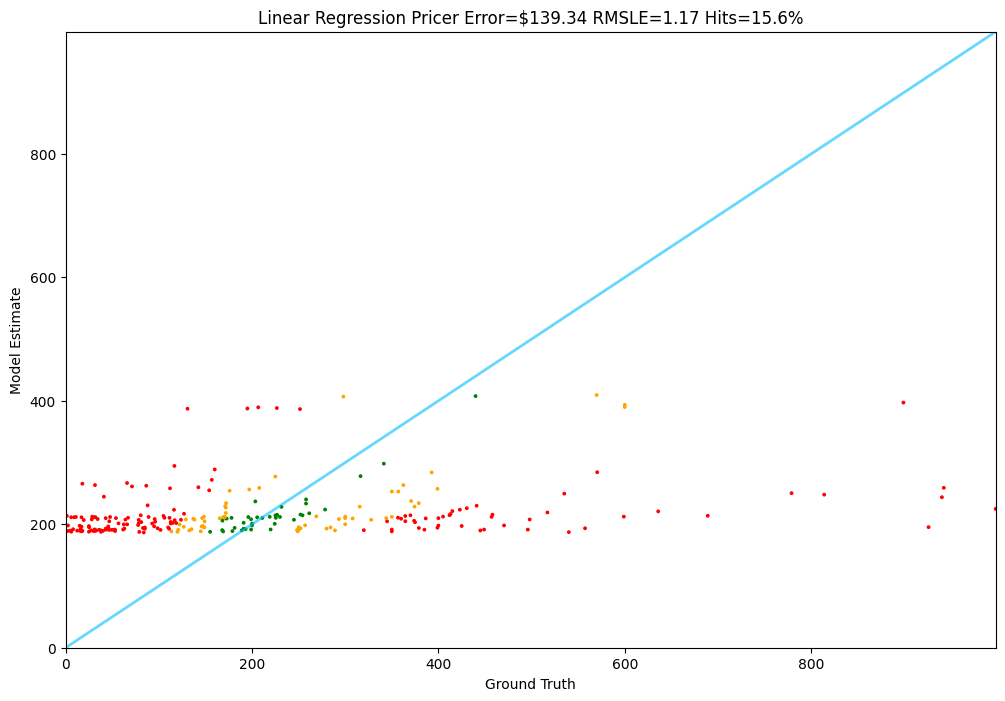

In [79]:
# test it

Tester.test(linear_regression_pricer)

In [80]:
# For the next few models, we prepare our documents and prices
# Note that we use the test prompt for the documents, otherwise we'll reveal the answer!!

prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [81]:
# Use the CountVectorizer for a Bag of Words model

np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X, prices)

LinearRegression()

In [82]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0], 0)

1: Guess: $296.58 Truth: $374.41 Error: $77.83 SLE: 0.05 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $165.14 Truth: $225.11 Error: $59.97 SLE: 0.09 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $162.26 Truth: $61.68 Error: $100.58 SLE: 0.92 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $326.14 Truth: $599.99 Error: $273.85 SLE: 0.37 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $51.69 Truth: $16.99 Error: $34.70 SLE: 1.15 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $74.06 Truth: $31.99 Error: $42.07 SLE: 0.68 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $344.82 Truth: $101.79 Error: $243.03 SLE: 1.47 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $241.39 Truth: $289.00 Error: $47.61 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $404.56 Truth: $635.86 Error: $231.30 SLE: 0.20 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $111.12 Truth: $65.99 Error: $45.13 SLE: 0

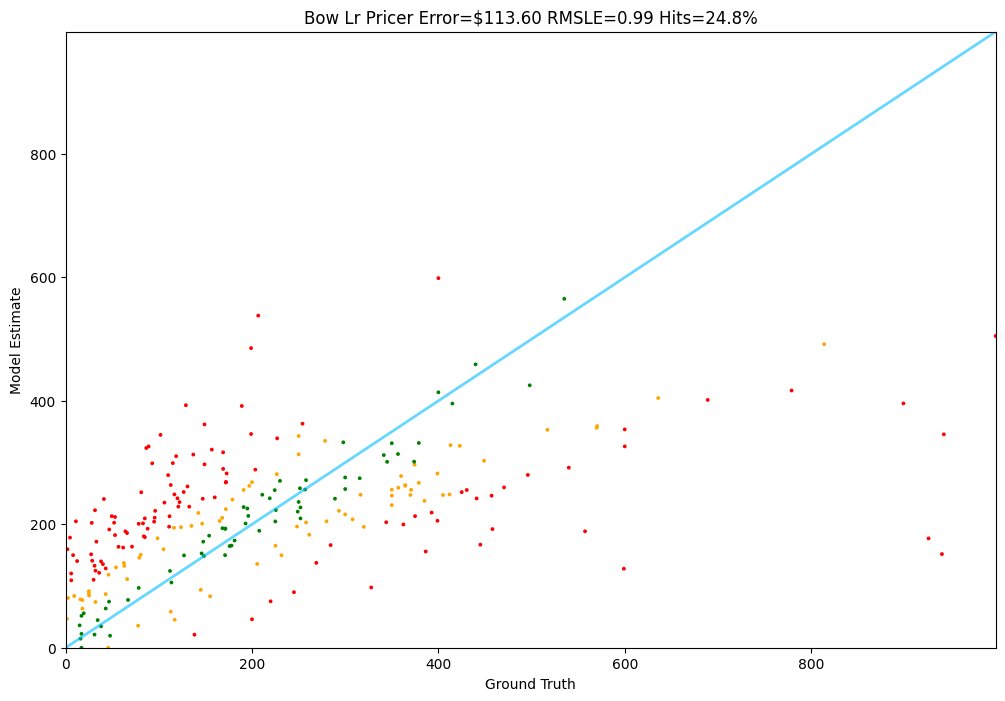

In [83]:
# test it

Tester.test(bow_lr_pricer)

In [84]:
# The amazing word2vec model, implemented in gensim NLP library

np.random.seed(42)

# Preprocess the documents
processed_docs = [simple_preprocess(doc) for doc in documents]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1, workers=8)

In [85]:
# This step of averaging vectors across the document is a weakness in our approach

def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

# Create feature matrix
X_w2v = np.array([document_vector(doc) for doc in documents])

In [86]:
# Run Linear Regression on word2vec

word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [87]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $229.97 Truth: $374.41 Error: $144.44 SLE: 0.24 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $178.36 Truth: $225.11 Error: $46.75 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $148.52 Truth: $61.68 Error: $86.84 SLE: 0.76 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $360.14 Truth: $599.99 Error: $239.85 SLE: 0.26 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $100.98 Truth: $16.99 Error: $83.99 SLE: 3.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $294.93 Truth: $101.79 Error: $193.14 SLE: 1.12 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $258.57 Truth: $289.00 Error: $30.43 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $329.73 Truth: $635.86 Error: $306.13 SLE: 0.43 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $132.35 Truth: $65.99 Error: $66.36 SLE: 

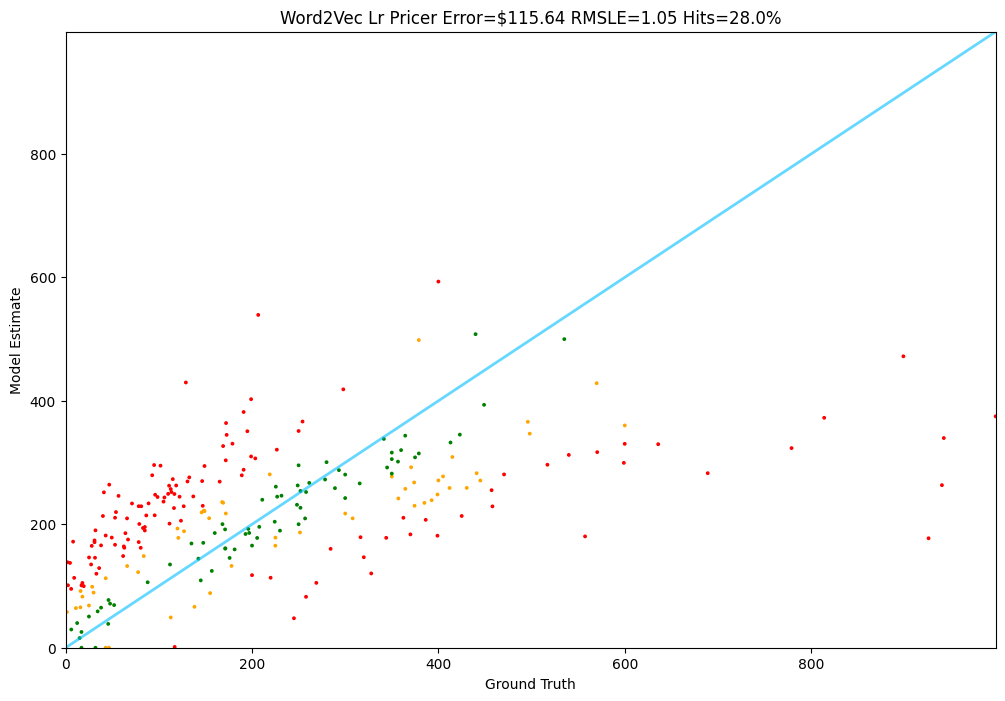

In [88]:
Tester.test(word2vec_lr_pricer)

In [89]:
# Support Vector Machines

np.random.seed(42)
svr_regressor = LinearSVR()

svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [90]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $238.12 Truth: $374.41 Error: $136.29 SLE: 0.20 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $184.91 Truth: $225.11 Error: $40.20 SLE: 0.04 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $131.52 Truth: $61.68 Error: $69.84 SLE: 0.56 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $312.31 Truth: $599.99 Error: $287.68 SLE: 0.42 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $89.58 Truth: $16.99 Error: $72.59 SLE: 2.61 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $240.98 Truth: $101.79 Error: $139.19 SLE: 0.73 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $186.34 Truth: $289.00 Error: $102.66 SLE: 0.19 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $276.91 Truth: $635.86 Error: $358.95 SLE: 0.69 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $104.01 Truth: $65.99 Error: $38.02 SLE: 

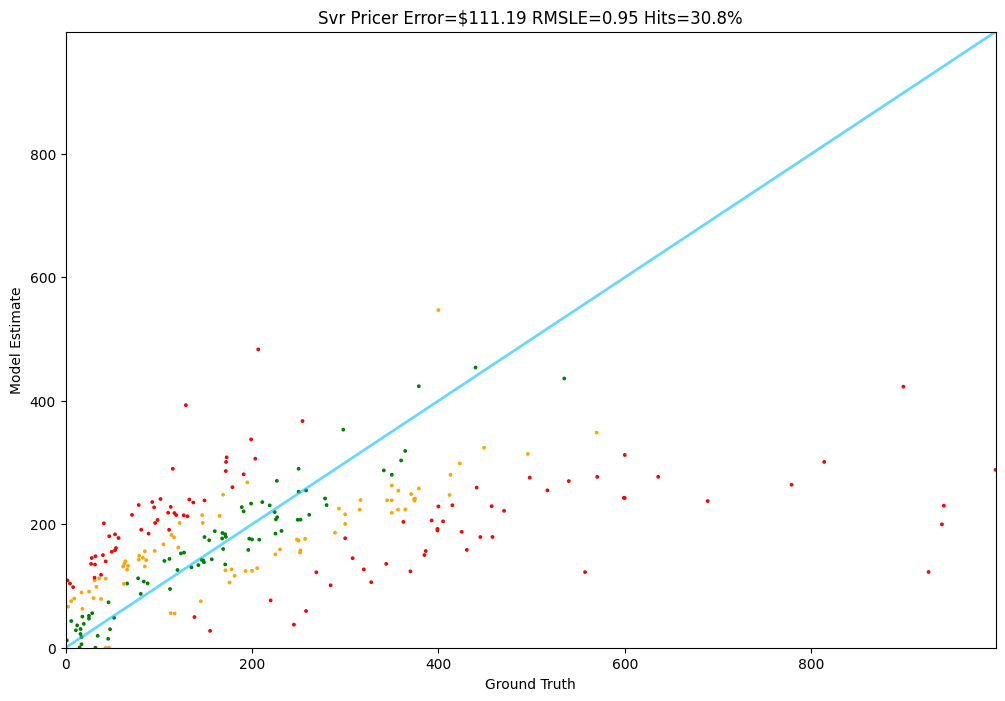

In [91]:
Tester.test(svr_pricer)

In [92]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [93]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $309.91 Truth: $374.41 Error: $64.50 SLE: 0.04 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $178.04 Truth: $225.11 Error: $47.07 SLE: 0.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $146.00 Truth: $61.68 Error: $84.32 SLE: 0.73 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $424.44 Truth: $599.99 Error: $175.55 SLE: 0.12 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $141.94 Truth: $16.99 Error: $124.95 SLE: 4.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $30.52 Truth: $31.99 Error: $1.47 SLE: 0.00 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $268.05 Truth: $101.79 Error: $166.26 SLE: 0.93 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $246.20 Truth: $289.00 Error: $42.80 SLE: 0.03 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $293.33 Truth: $635.86 Error: $342.53 SLE: 0.60 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $128.38 Truth: $65.99 Error: $62.39 SLE: 0

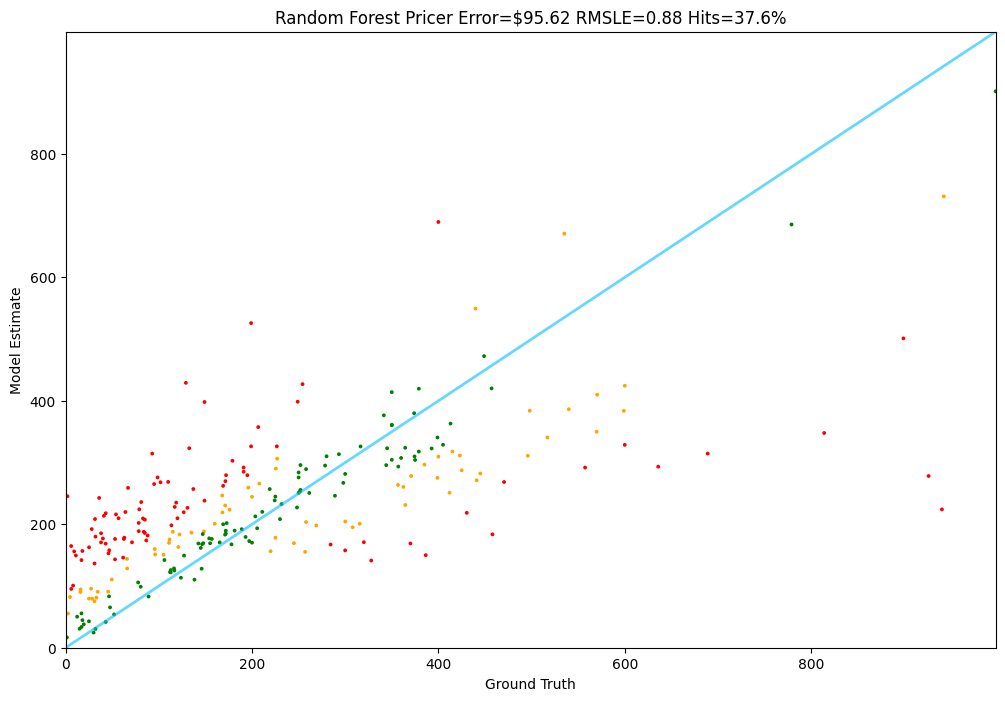

In [94]:
Tester.test(random_forest_pricer)

## Fine Tuning with Fontier model (GPT)

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the ***Test dataset*** to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [64]:
import re
import openai
from testing import Tester
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [55]:
%matplotlib inline

# Let's avoid curating all our data again! Load in the pickle files:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [56]:
# GPT-4o-mini

In [58]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [61]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [65]:
# A utility function to extract the price from a string
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [66]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [79]:
def gpt_4(item):
    response = openai.ChatCompletion.create(
        model="gpt-4",  # Use the correct model name (e.g., "gpt-4" or similar)
        messages=messages_for(item),
        max_tokens=5,
        temperature=0.7
    )
    reply = response['choices'][0]['message']['content']
    return get_price(reply)


In [73]:
test[0].price

374.41

In [80]:
gpt_4(test[0])

315.0

1: Guess: $315.00 Truth: $374.41 Error: $59.41 SLE: 0.03 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $132.99 Truth: $225.11 Error: $92.12 SLE: 0.27 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $650.00 Truth: $599.99 Error: $50.01 SLE: 0.01 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $25.00 Truth: $16.99 Error: $8.01 SLE: 0.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $59.99 Truth: $101.79 Error: $41.80 SLE: 0.27 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $269.00 Truth: $289.00 Error: $20.00 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $350.00 Truth: $635.86 Error: $285.86 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $139.99 Truth: $65.99 Error: $74.00 SLE: 0.55 It

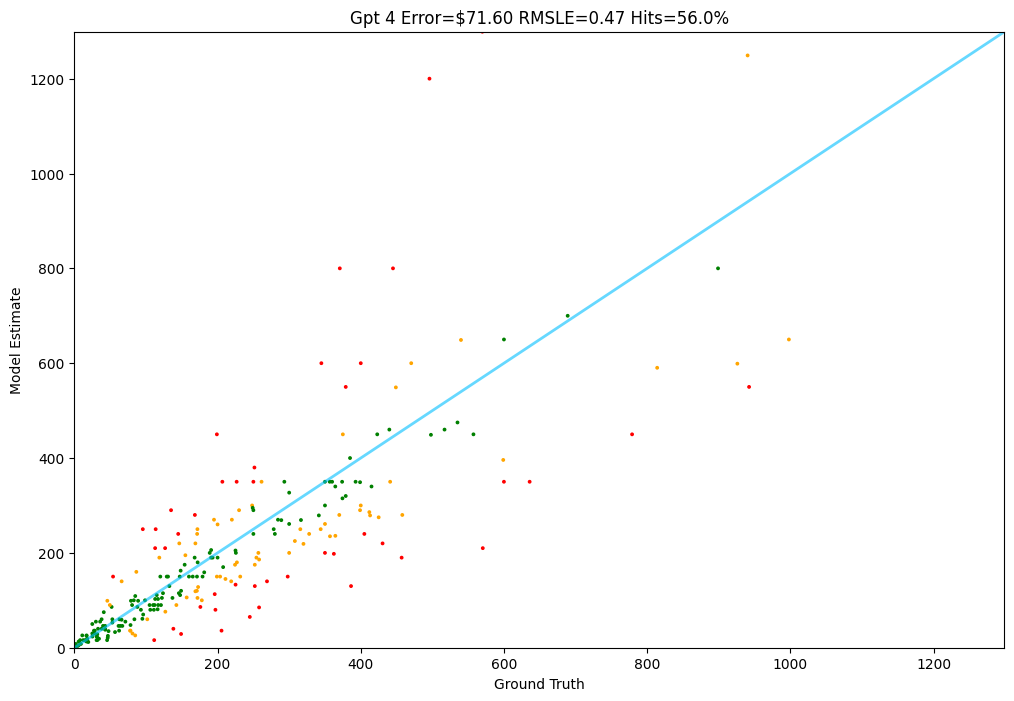

In [81]:
Tester.test(gpt_4, test)

In [76]:
# other models

def gpt_4o_frontier(item):
    response = openai.ChatCompletion.create(
        model="gpt-4o-2024-08-06",  # Use the correct model name (e.g., "gpt-4" or similar)
        messages=messages_for(item),
        max_tokens=5,
        temperature=0.7
    )
    reply = response['choices'][0]['message']['content']
    return get_price(reply)


In [77]:
gpt_4o_frontier(test[0])

280.0

1: Guess: $250.00 Truth: $374.41 Error: $124.41 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.00 Truth: $61.68 Error: $11.68 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.00 Truth: $16.99 Error: $1.99 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $90.00 Truth: $101.79 Error: $11.79 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $400.00 Truth: $635.86 Error: $235.86 SLE: 0.21 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.00 Truth: $65.99 Error: $6.99 SLE: 0.01 It

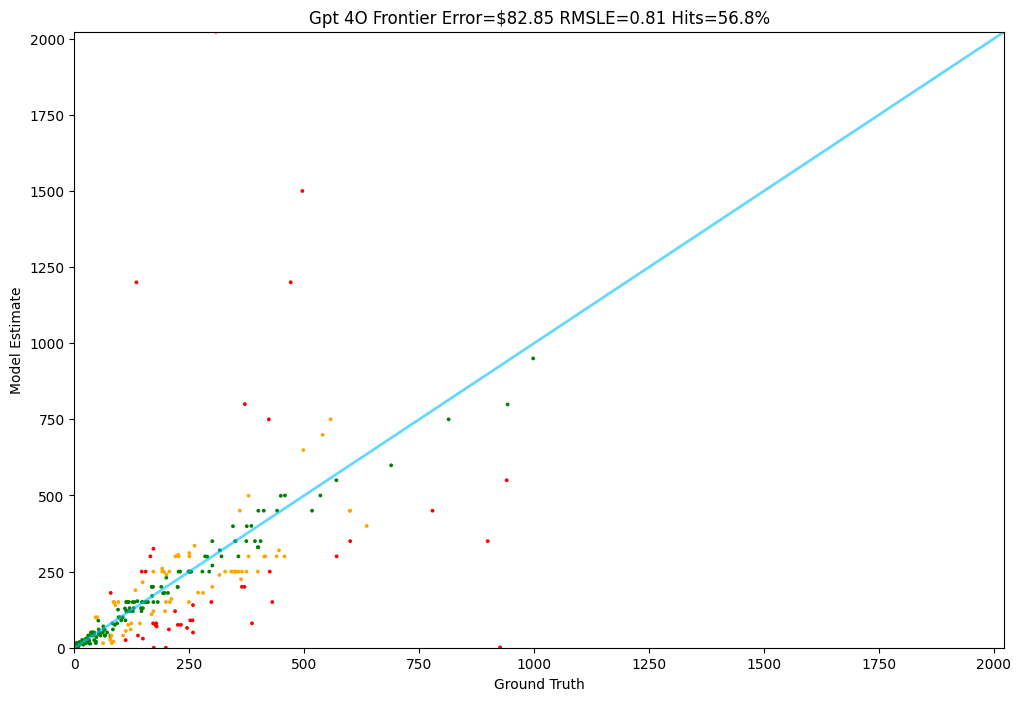

In [78]:
Tester.test(gpt_4o_frontier, test)